In [ ]:
import os
import time
import copy
import torch
import torch.optim
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score 
import torchvision.models as models
!pip install livelossplot --quiet
from livelossplot import PlotLosses
from torch.optim import lr_scheduler
from PIL import Image
from matplotlib import text
import matplotlib.pyplot as plt
from skimage import io, transform
import torchvision.models as models
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from joblib import dump, load

     |████████████████████████████████| 1.6 MB 38.5 MB/s 


In [ ]:
#upload the file and unzip it, or access the local file
!unzip terns.zip

In [ ]:
#directory contains images
PATH = '/content/terns'

# train-validation-test ratio
TRAIN = 0.7
VALID = 0.2
TEST = 0.1

# model parameters
batch_size = 100
n_epochs = 30
learningRate = 7e-4
sampling_num = 10

In [ ]:
def csv_to_df(root_path):
    '''
    split the dataset into two DataFrame;
    one is only contains Royal Terns;
    The another only contains Sandwich Terns;
    '''
    
    csv_files = list(filter(lambda x: x.endswith('.csv'), os.listdir(root_path)))
    columns = ['filename','old_class','new_class','new_desc',
               'xmin','ymin','xmax','ymax','mrk_X','mrk_Y']

    temp = []
    for path in csv_files:
        df = pd.read_csv(root_path + '/' + path, header=0, names=columns)
        df['filename'] = df['filename'].astype(str) + '.jpg'
        temp.append(df)

    data = pd.concat(temp, ignore_index=True)
    data = data[['filename', 'new_desc']]

    royal_terns = data[data['new_desc'].isin(['Royal Tern', 'Royal Tern no nest'])]
    # royal_terns = data[data['new_desc'].split(" ")[0].lower() == "royal"]
    royal_terns = royal_terns[['filename']]
    royal_terns['desc'] = 'ROTE'
    sandwich_terns = data[data['new_desc'].isin(['Sandwich Tern non nesting','Sandwich  Tern Nesting'])]
    # sandwich_terns = data[data['new_desc'].split(" ")[0].lower() == "sandwich"]
    sandwich_terns = sandwich_terns[['filename']]
    sandwich_terns['desc'] = 'SANE'

    return royal_terns, sandwich_terns

royal_terns, sandwich_terns = csv_to_df(PATH)

In [ ]:
print(len(royal_terns), len(sandwich_terns))

8228 4617


In [ ]:
def sample_select(number, royal_terns, sandwich_terns):
  '''
  number: is the tototal number of imgs that we want to use to train our model
  royal_terns: dataframe that contains only royal terns
  sandwich_terns: dataframe that contains only sandwich terns
  '''
  train = int(TRAIN * number)
  valid = int(VALID * number)
  # test = number - train - valid

  royal_set = royal_terns.sample(n=number//2, ignore_index=True)
  sand_set = sandwich_terns.sample(n=number//2, ignore_index=True)

  data_set = pd.concat([royal_set, sand_set], ignore_index=True)
  # print(data_set)
  train_set = data_set.sample(train)

  rest = data_set.drop(train_set.index)
  valid_set = rest.sample(valid)
  
  test_set = rest.drop(valid_set.index)

  train_set = train_set.reset_index(drop=True)
  valid_set = valid_set.reset_index(drop=True)
  test_set = test_set.reset_index(drop=True)
  
  return train_set, valid_set, test_set

In [ ]:
class TernsDataset(Dataset):

    """Terns dataset."""

    def __init__(self, pdframe, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_dir (string): The sorce data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # self.terns_frame = pd.read_csv(csv_dir, header=0, 
                                      #  names=['filename', 'new_class'])
        self.terns_frame = pdframe
        self.root_dir = root_dir
        self.transform = transform
        self.categories = ['ROTE', 'SANE']
        self.categories2ids = {category: id for (id, category) 
                               in enumerate(self.categories)}
                               

    def __len__(self):
        return len(self.terns_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.terns_frame.iloc[idx, 0])
        # image = io.imread(img_name)
        image = Image.open(img_name).convert('RGB')

        tern_species = self.terns_frame.iloc[idx, 1]
        label_id = self.categories2ids[tern_species]
        

        if self.transform:
            image = self.transform(image)
            
        return image, label_id

In [ ]:
train_set, valid_set, test_set = sample_select(100, royal_terns, sandwich_terns)
print(len(train_set))
print(len(valid_set))
print(len(test_set))

70
20
10


In [ ]:
# use this
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(), # data augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# Defining as global the device to use (by default CPU).
device = torch.device('cuda')

def train_model(batch_size, 
                n_epochs, 
                learningRate, 
                model, 
                dataset_sizes,
                cost_function, 
                optimizer,
                scheduler,
                dataloaders):
    # Move the model and cost function to GPU (if needed).
    model = model.to(device)
    cost_function = cost_function.to(device)
    
    liveloss = PlotLosses()

    since = time.time()

    # Keep track of best accuracy so far.
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(n_epochs):
        print(f'Epoch {epoch}/{n_epochs - 1}')
        print('-' * 10)
        logs = {}

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            tp, tn, fp, fn = 0, 0, 0, 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = cost_function(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    else: # count tp, tn, fp, fn
                        for idx in range(inputs.size(0)):
                            if labels[idx].item() == preds[idx].item() and labels[idx].item() == 0:
                                tp += 1
                            elif labels[idx].item() == preds[idx].item() and labels[idx].item() == 1:
                                tn += 1
                            elif labels[idx].item() != preds[idx].item() and labels[idx].item() == 0:
                                fn += 1
                            elif labels[idx].item() != preds[idx].item() and labels[idx].item() == 1:
                                fp += 1

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler != -1:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (running_corrects.double() / dataset_sizes[phase]).item()

            if phase == "train":
              logs["loss"] = epoch_loss
              logs["accuracy"] = epoch_acc
            else:
              logs['val_loss'] = epoch_loss
              logs['val_accuracy'] = epoch_acc              

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                f1Score = (tp / (tp + 0.5 * (fp + fn)))
        liveloss.update(logs)
        liveloss.send()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    print(f'F1 score of model with best val Acc: {f1Score:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc, f1Score

In [ ]:
def trainWithN_Imgs(num, data_transforms):
    '''
    num: is the number of imgs we will use in training our models
    '''
    resnet18 = models.resnet18(pretrained=True)
    model = resnet18
    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, 2)

    cost_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = learningRate, momentum=0.9)
    # exp_lr_scheduler = -1
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

    train_set, valid_set, test_set = sample_select(num, royal_terns, sandwich_terns)
    dataset_sizes = {"train": len(train_set), "val": len(valid_set)}
    training = TernsDataset(train_set, root_dir=PATH, transform=data_transforms["train"])
    validation = TernsDataset(valid_set, root_dir=PATH, transform=data_transforms["val"])

    train_loader = torch.utils.data.DataLoader(training, 
                                              batch_size = batch_size, 
                                              shuffle = True, 
                                              pin_memory = True,
                                              num_workers = 2)

    val_loader = torch.utils.data.DataLoader(validation, 
                                            batch_size = batch_size, 
                                            shuffle = False)
    
    dataloaders = {"train": train_loader, "val": val_loader}
    model, best_acc, f1Score = train_model(batch_size, n_epochs, learningRate, 
                    model, dataset_sizes, cost_function, optimizer, exp_lr_scheduler, 
                    dataloaders);

    return model, best_acc, f1Score

In [ ]:
def predict(model, dataloader):
  dev=torch.device("cuda")
  model.to(dev)
  # Set model to evaluate mode
  model.eval()   
  predictions = []
  yTrue = []

  with torch.no_grad():
    # Iterate over data.
    for inputs, labels in dataloader:
      yTrue.extend(labels)
      inputs, labels = inputs.cuda(), labels.cuda()
      outputs = model(inputs).detach().cpu().numpy()
      preds = outputs.argmax(axis=1)
      predictions.extend(preds)

  return np.array(predictions), np.array(yTrue)

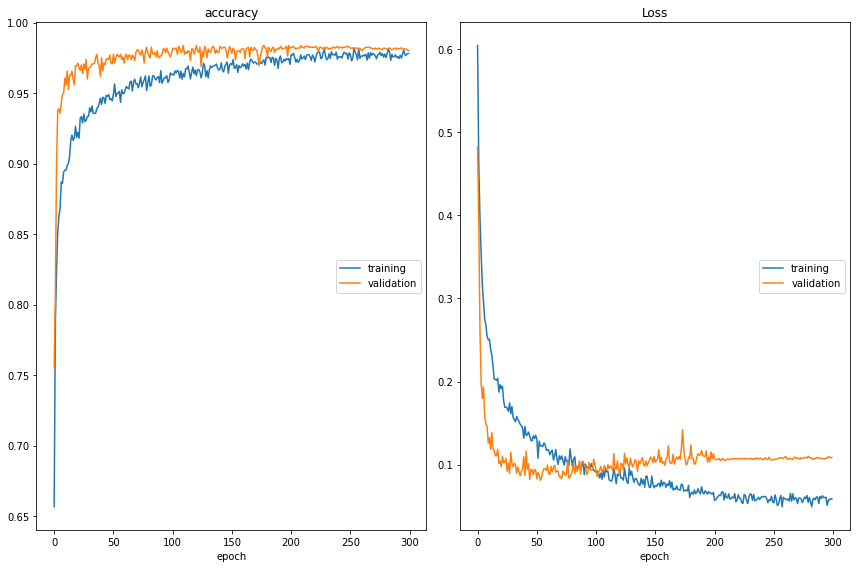

accuracy
	training         	 (min:    0.657, max:    0.982, cur:    0.978)
	validation       	 (min:    0.755, max:    0.984, cur:    0.980)
Loss
	training         	 (min:    0.049, max:    0.604, cur:    0.059)
	validation       	 (min:    0.081, max:    0.482, cur:    0.109)
Training complete in 124m 3s
Best val Acc: 0.983750
F1 score of model with best val Acc: 0.984088


In [ ]:
model, best_acc, f1Score = trainWithN_Imgs(8000, data_transforms)

In [ ]:
torch.save(model.state_dict(), "/content/modelWeights/model_weights.pth")

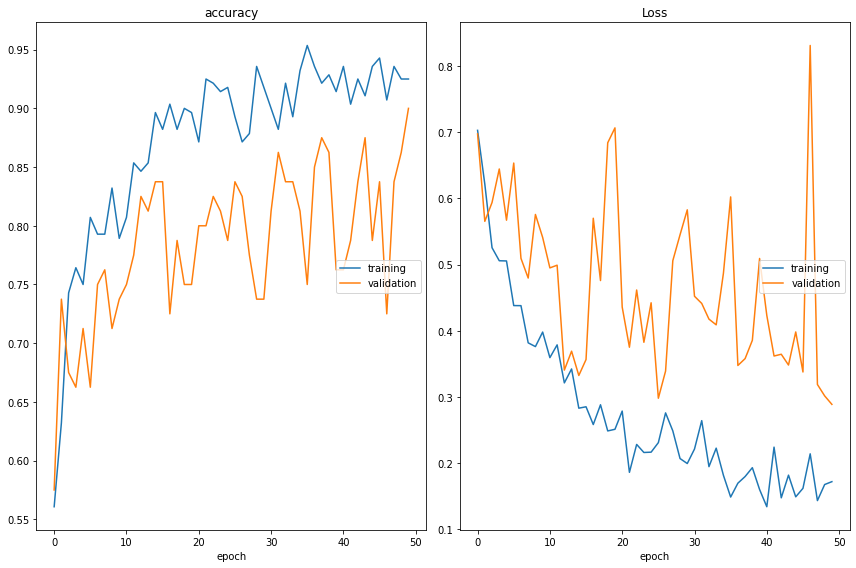

accuracy
	training         	 (min:    0.561, max:    0.954, cur:    0.925)
	validation       	 (min:    0.575, max:    0.900, cur:    0.900)
Loss
	training         	 (min:    0.134, max:    0.703, cur:    0.172)
	validation       	 (min:    0.289, max:    0.831, cur:    0.289)
Training complete in 1m 40s
Best val Acc: 0.900000
F1 score of model with best val Acc: 0.897436


In [ ]:
avg_acc, avg_fscore = [], []
for _ in range(sampling_num):
  tmp = trainWithN_Imgs(400, data_transforms)
  avg_acc.append(tmp[1])
  avg_fscore.append(tmp[2])

In [ ]:
print(avg_acc, sum(avg_acc)/sampling_num)

[0.9375, 0.9375, 0.9625, 0.925, 0.9625, 0.875, 0.925, 0.9625, 0.9375, 0.9] 0.9325000000000001


In [ ]:
print(avg_fscore, sum(avg_fscore)/sampling_num)

[0.945054945054945, 0.9411764705882353, 0.967032967032967, 0.9117647058823529, 0.963855421686747, 0.8913043478260869, 0.926829268292683, 0.9655172413793104, 0.9438202247191011, 0.8974358974358975] 0.9353791489898328


# Test

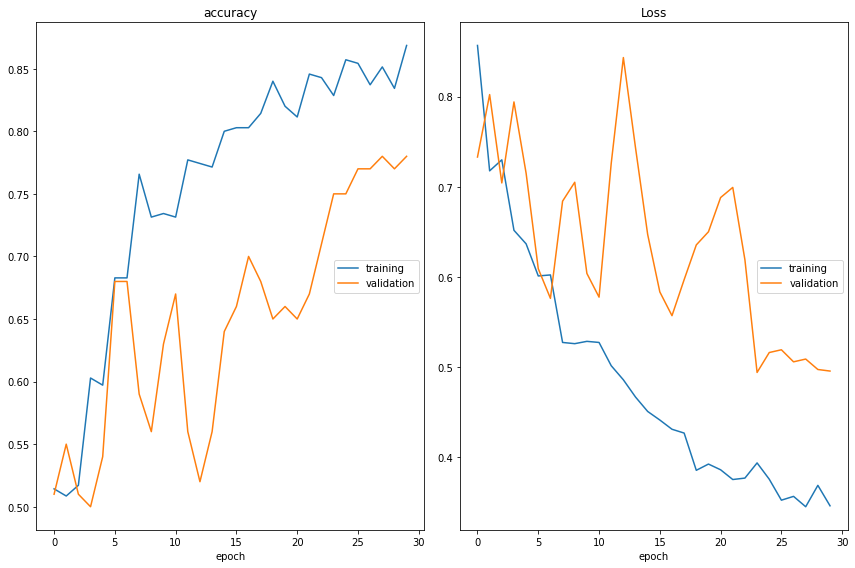

accuracy
	training         	 (min:    0.509, max:    0.869, cur:    0.869)
	validation       	 (min:    0.500, max:    0.780, cur:    0.780)
Loss
	training         	 (min:    0.345, max:    0.857, cur:    0.346)
	validation       	 (min:    0.494, max:    0.843, cur:    0.495)
Training complete in 1m 20s
Best val Acc: 0.780000
F1 score of model with best val Acc: 0.803571


In [ ]:
model, best_acc, f1Score = trainWithN_Imgs(500, data_transforms)

## Data set split ratio

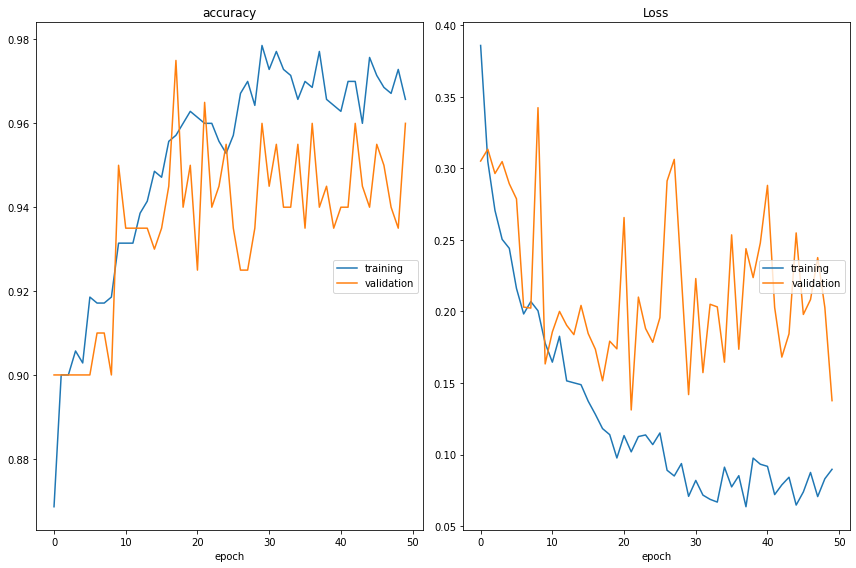

accuracy
	training         	 (min:    0.869, max:    0.979, cur:    0.966)
	validation       	 (min:    0.900, max:    0.975, cur:    0.960)
Loss
	training         	 (min:    0.064, max:    0.386, cur:    0.090)
	validation       	 (min:    0.131, max:    0.342, cur:    0.138)
Training complete in 3m 8s
Best val Acc: 0.975000
F1 score of model with best val Acc: 0.986301, 0.857143


In [ ]:
# f1 score for label 1, sandwich terns, and label 0 royal terns
ratio, accuracy, f1score0, f1score1 = [], [], [], []
for rat in np.arange(0.1, 1, 0.1):
  tmp = trainWithN_Imgs(1000, data_transforms, rat)
  ratio.append(rat)
  accuracy.append(tmp[0])
  f1score0.append(tmp[1])
  f1score1.append(tmp[2])


In [ ]:
print(ratio)
print(accuracy)
print(f1score0)
print(f1score1)

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]
[0.975, 0.98, 0.96, 0.96, 0.975, 0.97, 0.9550000000000001, 0.96, 0.975]
[0.8717948717948718, 0.9428571428571428, 0.9365079365079365, 0.9550561797752809, 0.9717514124293786, 0.975, 0.9672727272727273, 0.975, 0.9863013698630136]
[0.9861495844875346, 0.9878787878787879, 0.9708029197080292, 0.963963963963964, 0.9775784753363229, 0.9625, 0.928, 0.9, 0.8571428571428571]


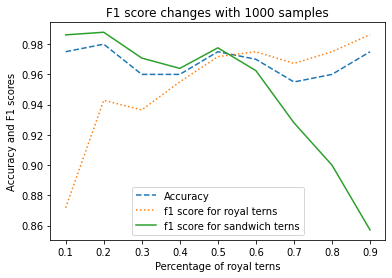

In [ ]:

fig, ax = plt.subplots()
ax.plot(ratio, accuracy, '--', label='Accuracy')
ax.plot(ratio, f1score0, ':', label='f1 score for royal terns')
ax.plot(ratio, f1score1, label='f1 score for sandwich terns')
ax.legend()
ax.set_xlabel('Percentage of royal terns')
ax.set_ylabel('Accuracy and F1 scores')
ax.set_title('F1 score changes with 1000 samples')
plt.show()